# Creating and Evaluating Predictors: Part 2 - Related Time Series

This notebook will build off of all the ealrier work and requires that at least the importing of target time series and related time series data be complete. If you have not performed those steps yet, go back, do so, then continue.

At this point you now have a target-time-series dataset and a related-time-series dataset loaded into a singular Dataset Group, this is what is required to leverage the models that support related data in Amazon Forecast. If your data supports item level metadata it could be added to the dataset group as well and would benefit only DeepAR+. 

To continue the work, start with the imports, determine your region, establish your API connections, and load all previously stored values

In [22]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [23]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-2


In [24]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

In [111]:
%store -r

## Creating and Training Predictors
 
Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on Prophet and DeepAR+ respectfully.


In [26]:
forecastHorizon = 480
NumberOfBacktestWindows = 4
BackTestWindowOffset = 480
ForecastFrequency = "H"

In [27]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

### Prophet

In [28]:
# Prophet Specifics
# Note the REL to indicate related time series data
prophet_predictorName= project+'_prophet_rel_algo_1'

In [29]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=prophet_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )




ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreatePredictor operation: A predictor already exists with the arn: arn:aws:forecast:us-east-2:057716757052:predictor/forecast_poc_gsmoon_prophet_rel_algo_1

### DeepAR+

In [30]:
# DeepAR+ Specifics
prophet_predictorName= project+'_deeparp_rel_algo_1'

In [31]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )





ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreatePredictor operation: A predictor already exists with the arn: arn:aws:forecast:us-east-2:057716757052:predictor/forecast_poc_gsmoon_deeparp_rel_algo_1

Normally in our notebooks we would have a while loop that polls for each of these to determine the status of the models in training. For simplicity sake here we are going to rely on you opening a new browser tab and following along in the console until a predictor has been created for each algorithm. 

Your previous tab from opening this session of Jupyter Lab should still be open, from there navigate to the Amazon Forecast service page, then select your dataset group. Lastly click `Predictors` and you should see the creation in progress. Once they are active you are ready to continue.

## Examining the Predictors

Once each of the Predictors is in an `Active` state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast

### Prophet

Here we are going to look to see the metrics from this Predictor like the earlier sessions, we will now add the related data metrics to the table from the previous notebook as well.

In [32]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2274.2036791767932,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.2656304356191758,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.38348172772011335,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.15561665025147906,
                                                                                          'Quantile': 0.1}]}},
                                            

Here we see an RMSE of 2337.240584382631 which is unfortunately a little worse than the original RMSE indicating that we may not be best served using related data for this algorithm.


| Predictor              | RMSE               | 10%                 | 50%                 | 90%                 |
|------------------------|--------------------|---------------------|---------------------|---------------------|
| ARIMA                  | 2315.5733958045103 | 0.18638100224895027 | 0.35619575117523433 | 0.2906928828133737  |
| Prophet                | 2326.907237203276  | 0.15434241067213655 | 0.3880618345549856  | 0.28403268455977804 |
| Prophet + Related Data | 2337.240584382631  | 0.15668701263879603 | 0.38782245560595247 | 0.28403480713820367 |
| DeepAR+                | 2343.76942963439   | 0.09470210806720818 | 0.27579575099681214 | 0.32289195793540876 |

When digging into the metrics we did not see a single improvement to Prophet, next let us see how DeepAR+ performed.


### DeepAR+

Same as Prophet, now you should look at the metrics from it.

In [33]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2195.9178774101083,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.22705683334712132,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.31427349906573443,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.12325873846486546,
                                                                                          'Quantile': 0.1}]}},
                                      

Now after training with DeepAR+ we can seen an RMSE of 2339.5169670021673 which is still not ideal but the full break down is:


| Predictor              | RMSE               | 10%                 | 50%                 | 90%                 |
|------------------------|--------------------|---------------------|---------------------|---------------------|
| ARIMA                  | 2315.5733958045103 | 0.18638100224895027 | 0.35619575117523433 | 0.2906928828133737  |
| Prophet                | 2326.907237203276  | 0.15434241067213655 | 0.3880618345549856  | 0.28403268455977804 |
| Prophet & Related Data | 2337.240584382631  | 0.15668701263879603 | 0.38782245560595247 | 0.28403480713820367 |
| DeepAR+                | 2343.76942963439   | 0.09470210806720818 | 0.27579575099681214 | 0.32289195793540876 |
| DeepAR+ & Related Data | 2339.5169670021673 | 0.09773726043488253 | 0.2809238443812311  | 0.30924327596172524 |


From this table we can see that DeepAR+ with the related data is th eleader for the 10% and 50% quantiles. If you are predicting in this range then it is a clear leader for usage. However if 90% is the target then Prophet without related data is the leader for now.

Additional work would need to be kicked off from here to determine the specific impact of these figures and how they compare to the existing Forecasting approaches performed by your customer.


## 포케스트 생성하기

In [34]:
print(prophet_arn)

arn:aws:forecast:us-east-2:057716757052:predictor/forecast_poc_gsmoon_prophet_rel_algo_1


In [35]:
# Prophet
prophet_forecastName = project+'_prophet_rel_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_forecastName,
                                                  PredictorArn=prophet_arn)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [36]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_rel_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

## 결과를 S3 에 내보내기

In [38]:
prophet_path = "s3://" + bucket_name + "/prophet_rel_1/"
prophet_job_name = "ProphetExport1_rel"
forecast.create_forecast_export_job(ForecastExportJobName=prophet_job_name,
                                                        ForecastArn=prophet_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": prophet_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-2:057716757052:forecast-export-job/forecast_poc_gsmoon_prophet_rel_algo_forecast/ProphetExport1_rel',
 'ResponseMetadata': {'RequestId': '5e7d9e89-afe0-4293-bd59-302dab3fae29',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 09 Mar 2020 08:32:30 GMT',
   'x-amzn-requestid': '5e7d9e89-afe0-4293-bd59-302dab3fae29',
   'content-length': '151',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [75]:
deeparp_path = "s3://" + bucket_name + "/deeparp_rel_1/"
deeparp_job_name = "DeepARPExport1_rel"
forecast.create_forecast_export_job(ForecastExportJobName=deeparp_job_name,
                                                        ForecastArn=deeparp_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": deeparp_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-2:057716757052:forecast-export-job/forecast_poc_gsmoon_deeparp_rel_algo_forecast/DeepARPExport1_rel',
 'ResponseMetadata': {'RequestId': '0a751cb8-16b7-439c-81d0-ff04960aabc5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 09 Mar 2020 10:01:30 GMT',
   'x-amzn-requestid': '0a751cb8-16b7-439c-81d0-ff04960aabc5',
   'content-length': '151',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Obtaining the Forecasts from S3

In [39]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)

prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix="prophet_rel_1"))
print("prophet_files: ", prophet_files)
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+prophet_filename)
print(prophet_filename)

prophet_files:  [s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='prophet_rel_1/ProphetExport1_rel_2020-03-09T08-33-37Z_part0.csv'), s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='prophet_rel_1/_CHECK'), s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='prophet_rel_1/_SUCCESS')]
ProphetExport1_rel_2020-03-09T08-33-37Z_part0.csv


In [78]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix="deeparp_rel_1"))
print(deeparp_files)
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+deeparp_filename)
print(deeparp_filename)

[s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='deeparp_rel_1/DeepARPExport1_rel_2020-03-09T10-02-26Z_part0.csv'), s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='deeparp_rel_1/_CHECK'), s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='deeparp_rel_1/_SUCCESS')]
DeepARPExport1_rel_2020-03-09T10-02-26Z_part0.csv


### Prophet Validation

In [64]:
prophet_rel_predicts = pd.read_csv(data_dir + "/" + prophet_filename)
prophet_rel_predicts.sample()

,item_id,date,weather,p10,p50,p90
341,1,2018-01-15T05:00:00Z,sky is clear,-136.602961,2368.50697,5396.112453


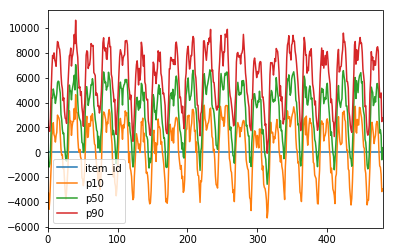

In [65]:
prophet_rel_predicts.plot()

In [66]:
# Convert the column to datetime
prophet_rel_predicts['date'] = pd.to_datetime(prophet_rel_predicts['date'])

In [67]:
# Remove the timezone and make date the index
prophet_rel_predicts['date'] = prophet_rel_predicts['date'].dt.tz_convert(None)
prophet_rel_predicts.set_index('date', inplace=True)

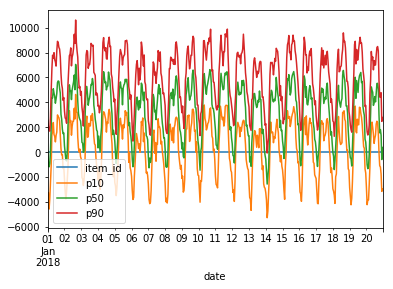

In [68]:
prophet_rel_predicts.plot()

In [69]:
prophet_rel_predicts = prophet_rel_predicts[['p10', 'p50', 'p90']]

2018-01-01 00:00:00
2018-01-20 23:00:00


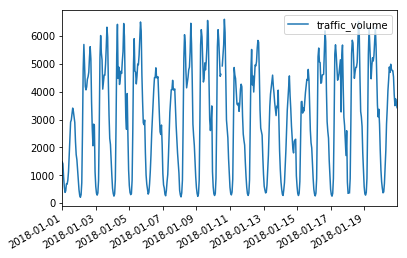

In [70]:
# Lets slice validation to meet our needs
validation_df = validation_time_series_df.copy()
validation_df = validation_df.loc['2018-01-01':'2018-01-20']
print (validation_df.index.min())
print (validation_df.index.max())
validation_df.plot()

In [96]:
# Finally let us join the dataframes together
prophet_val_df = prophet_rel_predicts.join(validation_df, how='outer')

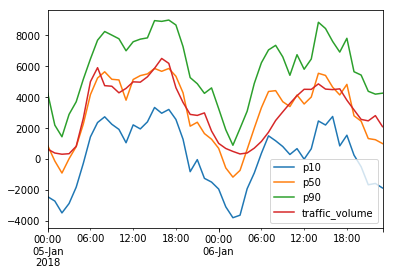

In [97]:
prophet_rel_val_df_jan_5 = prophet_val_df.loc['2018-01-05':'2018-01-06']
prophet_rel_val_df_jan_5.plot()

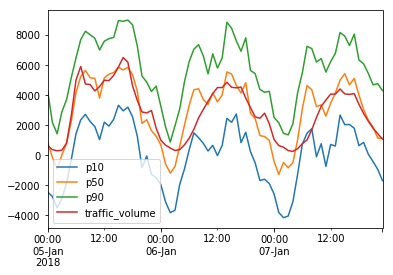

In [115]:
prophet_rel_val_df_jan_5_7 = prophet_val_df.loc['2018-01-05':'2018-01-07']
prophet_rel_val_df_jan_5_7.plot()

### DeepAR+ Validation

In [98]:
# DeepAR+ Eval
deeparp_rel_predicts = pd.read_csv(data_dir+"/"+deeparp_filename)
deeparp_rel_predicts.sample()
# Remove the timezone
deeparp_rel_predicts['date'] = pd.to_datetime(deeparp_rel_predicts['date'])
deeparp_rel_predicts['date'] = deeparp_rel_predicts['date'].dt.tz_convert(None)
deeparp_rel_predicts.set_index('date', inplace=True)
deeparp_rel_predicts = deeparp_rel_predicts[['p10', 'p50', 'p90']]
# Finally let us join the deeparp_rel_predicts together
deeparp_val_df = deeparp_rel_predicts.join(validation_df, how='outer')

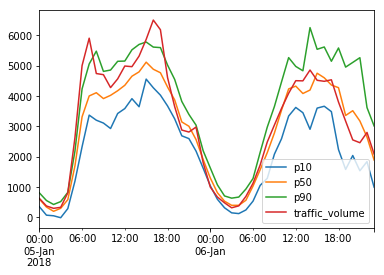

In [99]:
deeparp_rel_val_df_jan_5 = deeparp_val_df.loc['2018-01-05':'2018-01-06']
deeparp_rel_val_df_jan_5.plot()

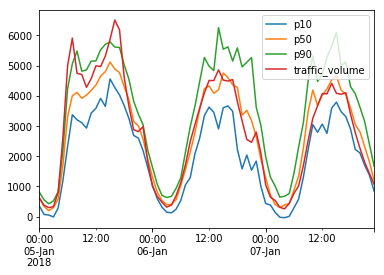

In [116]:
deeparp_rel_val_df_jan_5_7 = deeparp_val_df.loc['2018-01-05':'2018-01-07']
deeparp_rel_val_df_jan_5_7.plot()

### Comparison
* Multiple Chart Reference:
    * https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html 
    * https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots

### Prophet_Rel Vs. DeepAR+_Rel

In [107]:
def show_two_chart_horizontal(title, df1, sub_title1, df2, sub_title2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(title)

    fig.set_figwidth(16)
    fig.set_figheight(4)

    ax1.title.set_text(sub_title1)
    ax2.title.set_text(sub_title2)
    df1.plot(ax=ax1)
    df2.plot(ax=ax2)    

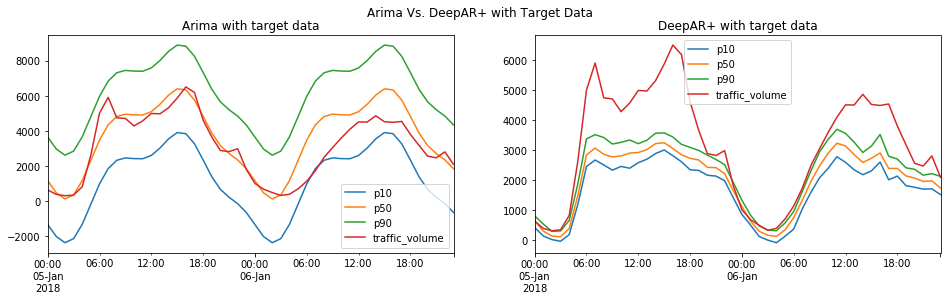

In [110]:
show_two_chart_horizontal("Arima Vs. DeepAR+ with Target Data", 
                          arima_val_df_jan_5, 
                          "Arima with target data", 
                          deeparp_val_df_jan_5,
                          "DeepAR+ with target data", 
                         )


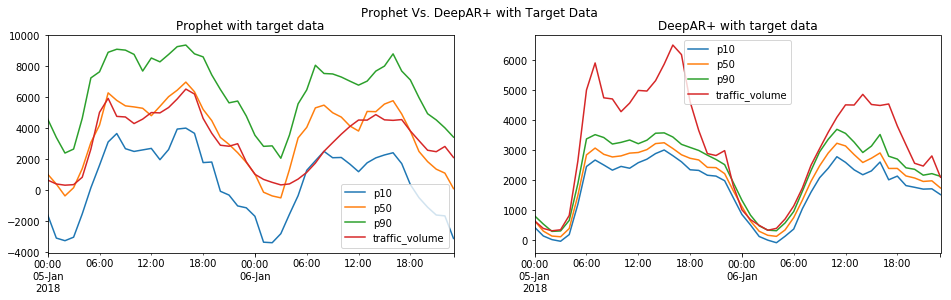

In [108]:
show_two_chart_horizontal("Prophet Vs. DeepAR+ with Target Data", 
                          prophet_val_df_jan_5, 
                          "Prophet with target data", 
                          deeparp_val_df_jan_5,
                          "DeepAR+ with target data", 
                         )


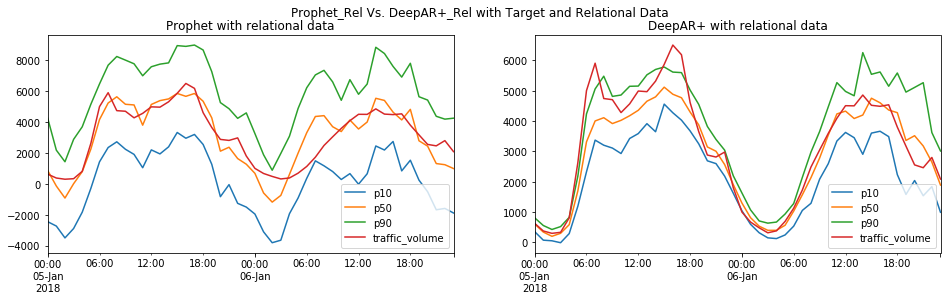

In [109]:
show_two_chart_horizontal("Prophet_Rel Vs. DeepAR+_Rel with Target and Relational Data", 
                          prophet_rel_val_df_jan_5, 
                          "Prophet with relational data", 
                          deeparp_rel_val_df_jan_5,
                          "DeepAR+ with relational data", 
                         )


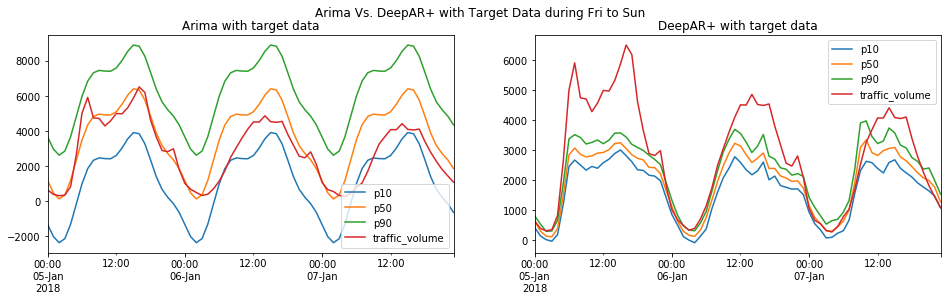

In [113]:
show_two_chart_horizontal("Arima Vs. DeepAR+ with Target Data during Fri to Sun", 
                          arima_val_df_jan_5_7, 
                          "Arima with target data", 
                          deeparp_val_df_jan_5_7,
                          "DeepAR+ with target data", 
                         )


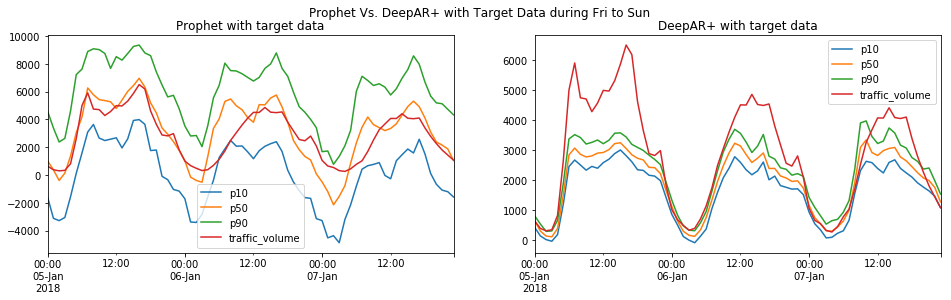

In [114]:
show_two_chart_horizontal("Prophet Vs. DeepAR+ with Target Data during Fri to Sun", 
                          prophet_val_df_jan_5_7, 
                          "Prophet with target data", 
                          deeparp_val_df_jan_5_7,
                          "DeepAR+ with target data", 
                         )


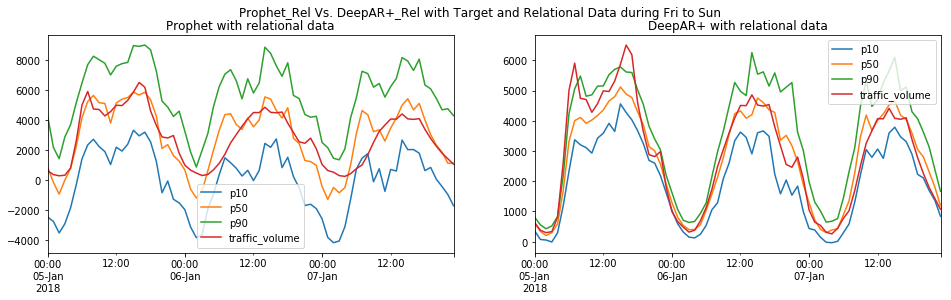

In [117]:
show_two_chart_horizontal("Prophet_Rel Vs. DeepAR+_Rel with Target and Relational Data during Fri to Sun", 
                          prophet_rel_val_df_jan_5_7, 
                          "Prophet with relational data", 
                          deeparp_rel_val_df_jan_5_7,
                          "DeepAR+ with relational data", 
                         )


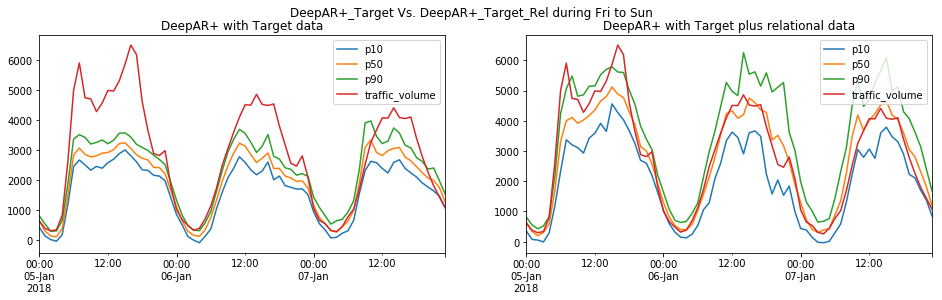

In [118]:
show_two_chart_horizontal("DeepAR+_Target Vs. DeepAR+_Target_Rel during Fri to Sun", 
                          deeparp_val_df_jan_5_7, 
                          "DeepAR+ with Target data", 
                          deeparp_rel_val_df_jan_5_7,
                          "DeepAR+ with Target plus relational data", 
                         )
